In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
data_dir = "../data/"

In [3]:
df = pd.read_csv("../data/FaceScore.csv")

In [4]:
df.head()

,Filename,Rating
0,ftw1.jpg,4.083333
1,ftw10.jpg,3.666667
2,ftw100.jpg,1.916667
3,ftw101.jpg,2.416667
4,ftw102.jpg,3.166667


In [5]:
rating = df.pop('Rating')
# rating = (rating - np.mean(rating))/np.std(rating)

In [7]:
images = []
for i in tqdm(range(df.shape[0])):
    img = image.image_utils.load_img('../data/images/'+df['Filename'][i])
    img = image.image_utils.img_to_array(img)
    img = image.image_utils.smart_resize(img, (227, 227))
    img = img/255
    images.append(img)

100%|██████████| 5500/5500 [00:41<00:00, 131.38it/s]


In [8]:
images = tf.convert_to_tensor(images, dtype=tf.float32)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((images, rating.values))

In [10]:
train_size = int(5500 * 0.7)
test_size = int(5500 * 0.15)
val_size = int(5500 * 0.15)

In [11]:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

In [12]:
train_ds = train_ds.shuffle(buffer_size=train_size).batch(32, drop_remainder=True)
test_ds = test_ds.shuffle(buffer_size=test_size).batch(32, drop_remainder=True)
val_ds = val_ds.shuffle(buffer_size=test_size).batch(32, drop_remainder=True)

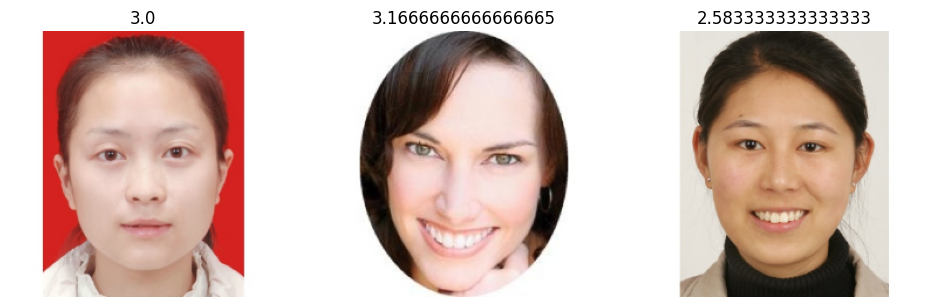

In [13]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(3)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image[0])
    plt.title(str(label[0].numpy()))
    plt.axis('off')

In [18]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

In [19]:
model.compile(loss='mse', optimizer=tf.optimizers.SGD(learning_rate=0.01), metrics=['mae', 'mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

In [20]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds,
          validation_freq=1)

Epoch 1/20


2022-10-11 14:50:20.739600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 116018409943793718525952.0000 - mae: 57759322112.0000 - mse: 116018409943793718525952.0000

2022-10-11 14:50:34.232323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 15s 118ms/step - loss: 116018409943793718525952.0000 - mae: 57759322112.0000 - mse: 116018409943793718525952.0000 - val_loss: 46811672368191111168.0000 - val_mae: 6841907200.0000 - val_mse: 46811672368191111168.0000
Epoch 2/20
120/120 [==============================] - 14s 117ms/step - loss: 9773717188975263744.0000 - mae: 2598390528.0000 - mse: 9773717188975263744.0000 - val_loss: 366954309188845568.0000 - val_mae: 605767616.0000 - val_mse: 366954309188845568.0000
Epoch 3/20
120/120 [==============================] - 14s 117ms/step - loss: 76615731160023040.0000 - mae: 230055952.0000 - mse: 76615731160023040.0000 - val_loss: 2876538240368640.0000 - val_mae: 53633392.0000 - val_mse: 2876538240368640.0000
Epoch 4/20
120/120 [==============================] - 14s 120ms/step - loss: 600587020271616.0000 - mae: 20368666.0000 - mse: 600587020271616.0000 - val_loss: 22549056454656.0000 - val_mae: 4748584.5000 - val_mse: 22549056454656.0000
Epoch 5/2

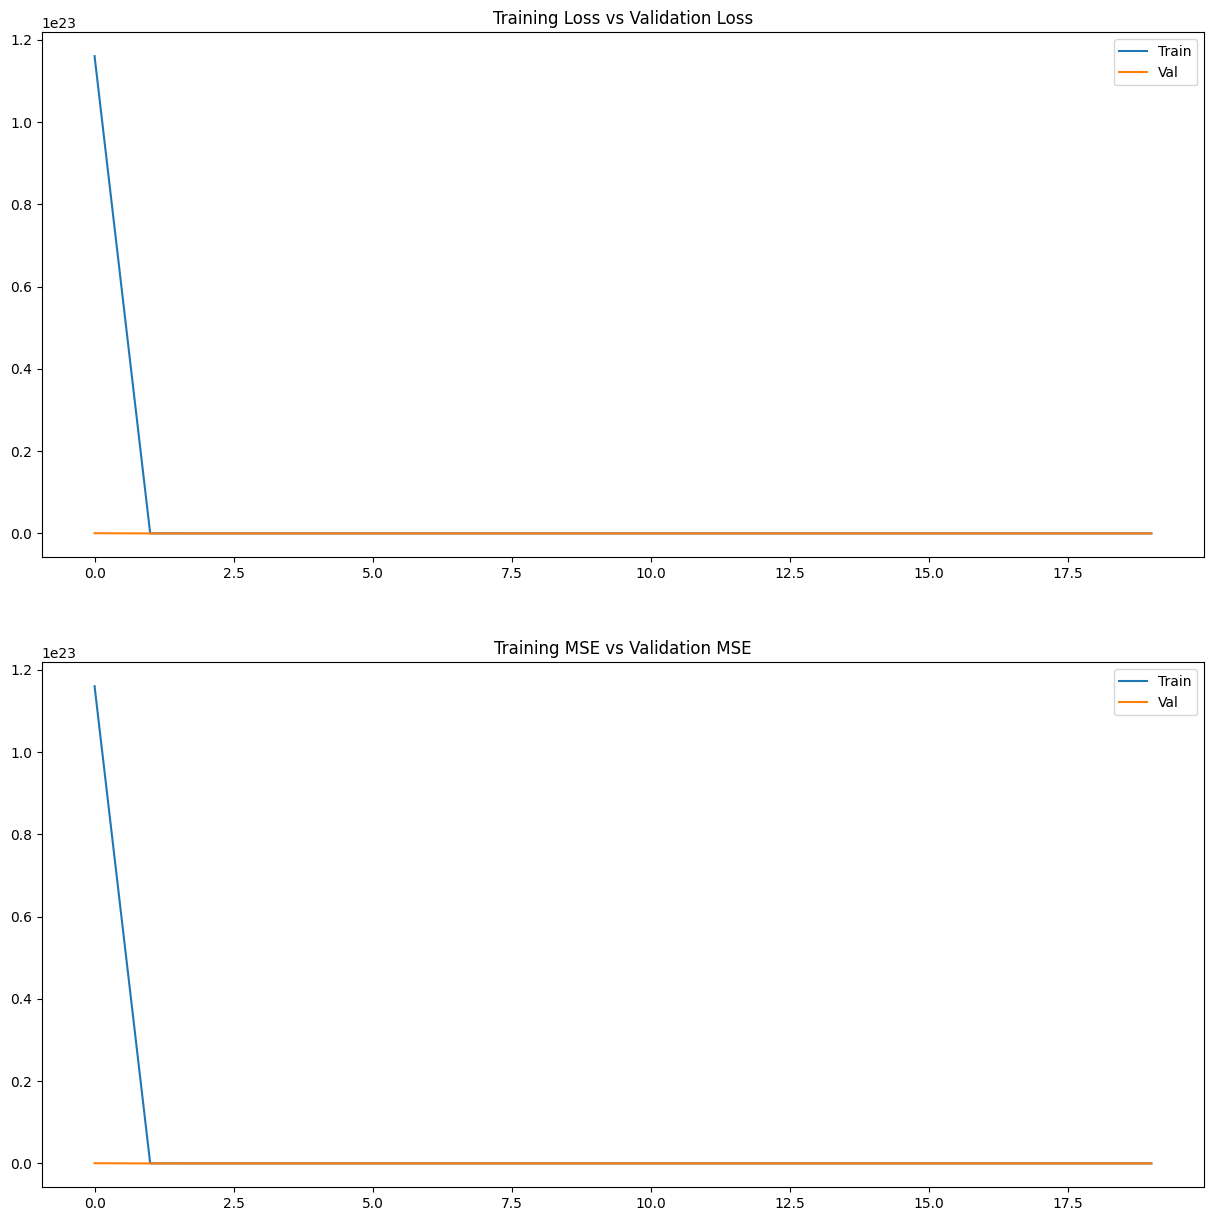

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))  
axs[0].plot(history.history['loss']) 
axs[0].plot(history.history['val_loss']) 
axs[0].title.set_text('Training Loss vs Validation Loss') 
axs[0].legend(['Train', 'Val'])  
axs[1].plot(history.history['mse']) 
axs[1].plot(history.history['val_mse']) 
axs[1].title.set_text('Training MSE vs Validation MSE') 
axs[1].legend(['Train', 'Val'])

In [22]:
model.evaluate(test_ds)

25/25 [==============================] - 2s 30ms/step - loss: 0.5290 - mae: 0.6241 - mse: 0.5290


[0.5289878249168396, 0.6241111755371094, 0.5289878249168396]